# Seasonal Autoregressive Integrated Moving Average with Exogenous Regressors
### Model for time series forecasting with data containing trends and/or seasonality _and_ exogenous variables

In [175]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from statsmodels.tsa.statespace.sarimax import SARIMAX

Reading in CDC data and exogenous variables

In [176]:
df_hospital = pd.read_csv('../data/hospital_visits.csv')
df_hospital['Week'] = df_hospital.Week.map(str) + "-" + df_hospital.Year.map(str)
df_hospital = df_hospital[['Week', 'Total ILI']]
df_hospital.columns = ['Week', 'ILI']
df_hospital = df_hospital[28:256]
df_hospital = df_hospital.reset_index(drop=True)

df_twitter = pd.read_csv('../data/twitter-flu-data.csv', header=None)
df_twitter.columns = ['Year', 'Week', '1', '2', '3', '4', '5', '6', '7']
df_twitter['Week'] = df_twitter.Week.map(str) + "-" + df_twitter.Year.map(str)
df_twitter['Tweets'] = df_twitter[['1', '2', '3', '4', '5', '6', '7']].sum(axis=1)
df_twitter = df_twitter[['Week', 'Tweets']][27:-1]
df_twitter = df_twitter.reset_index(drop=True)

df_us = pd.read_csv('../data/USA_flu_virus_counts.csv')
df_us['Week'] = df_us.Week.map(str) + "-" + df_us.Year.map(str)
df_us = df_us[['Week', 'ALL_INF']]
df_us = df_us[786+27:1042]
df_us = df_us.drop(851)
df_us = df_us.reset_index(drop=True)

df_aus = pd.read_csv('../data/AUS_flu_virus_counts.csv')
df_aus['Week'] = df_aus.Week.map(str) + "-" + df_aus.Year.map(str)
df_aus = df_aus[['Week', 'ALL_INF']]
df_aus = df_aus[912:1168-27]
df_aus = df_aus.drop(977)
df_aus = df_aus.reset_index(drop=True)

df_google = pd.read_csv('../data/google_trends/flu_related_trends.csv')
df_google['Week'] = df_google.Week.map(str) + "-" + df_google.Year.map(str)
df_google = df_google[['Week', 'flu season', 'flu shot', 'flu symptoms', 'flu', 'flu vaccine', 'flu vs cold', 'cold flu', 'flu virus', 'stomach flu']]
df_google = df_google[17:246]
df_google = df_google.drop(159)
df_google = df_google.reset_index(drop=True)

In [177]:
list_hospital = list(df_hospital['ILI'])
list_tweets = list(df_twitter['Tweets'])
list_us = list(df_us['ALL_INF'])
list_aus = list(df_aus['ALL_INF'])
list_google = df_google[['flu season', 'flu shot', 'flu symptoms', 'flu', 'flu vaccine', 'flu vs cold', 'cold flu', 'flu virus', 'stomach flu']].values.tolist()

In [178]:
list_hospital_real = list_hospital[:-52]
list_tweets_real = list_tweets[:-52]
list_us_real = list_us[:-52]
list_aus_real = list_aus[:-52]
list_google_real = list_google[:-52]

list_hospital_pred = list_hospital[-52:]
list_tweets_pred = list_tweets[-52:]
list_us_pred = list_us[-52:]
list_aus_pred = list_aus[-52:]
list_google_pred = list_google[-52:]

In [179]:
features_transposed = [list_tweets_real, list_aus_real]
pred_transposed = [list_tweets_pred, list_aus_pred]

features = list(map(list, zip(*features_transposed)))
pred = list(map(list, zip(*pred_transposed)))

for feature_index in range(len(features)):
    features[feature_index].extend(list_google_real[feature_index])

for pred_index in range(len(pred)):
    pred[pred_index].extend(list_google_pred[pred_index])

google_transposed = list(map(list, zip(*list_google)))
to_plot_transposed = [list_tweets, list_aus]
to_plot_transposed.extend(google_transposed)

#### Defining the SARIMAX model - forecasting the last 52 weeks
Optimal order and seasonal_order (found via hyperparameter tuning in sarimax-script.py)

In [180]:
model = SARIMAX(endog=list_hospital_real, exog=features, order=(0, 1, 0), seasonal_order=(2, 1, 0, 52), enforce_stationarity=False, enforce_invertibility=False, trend='c')
model_fit = model.fit()

C:\Users\steph\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [181]:
future = 52
predictions = model_fit.predict(len(list_hospital_real), len(list_hospital_real) + future - 1, exog=pred)
future_weeks = list(range(len(list_hospital_real), len(list_hospital_real) + future))

In [182]:
predictions_df = pd.DataFrame([future_weeks, predictions]).transpose()
predictions_df.columns = ['Week', 'Total ILI']
predictions_df = predictions_df.set_index('Week')

Text(0.5, 1.0, 'Total ILI: 2015-2016 to 2018-2019 + predictions \n(flu-related Google search terms)')

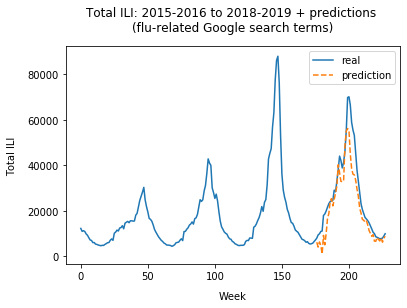

In [183]:
plt.plot(df_hospital['ILI'], label='real')
plt.plot(predictions_df, '--', label='prediction')
plt.legend()
plt.xlabel("Week", labelpad=10)
plt.ylabel("Total ILI", labelpad=10)
plt.title("Total ILI: 2015-2016 to 2018-2019 + predictions \n(flu-related Google search terms)", pad=15)

In [184]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  176
Model:             SARIMAX(0, 1, 0)x(2, 1, 0, 52)   Log Likelihood                -137.515
Date:                            Tue, 10 Dec 2019   AIC                            305.030
Time:                                    23:01:09   BIC                            319.197
Sample:                                         0   HQIC                           307.428
                                            - 176                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -19.2588    129.257     -0.149      0.882    -272.597     234.079
x1            -8.7696     14.065     -0.624      0.533     -36.336      18.797
x2           -13.2822     21.540     -0.617      0.537     -55.501      28.936
x3          -101.8364    453.541     -0.225      0.822    -990.760     787.087
x4          -305.7951    272.277     -1.123      0.261    -839.448     227.858
x5           603.9824    466.648      1.294      0.196    -310.631    1518.595
x6           256.2328    603.661      0.424      0.671    -926.920    1439.386
x7            27.0119    170.766      0.158      0.874    -307.684     361.708
x8           -18.3818    284.105     -0.065      0.948    -575.217     538.453
x9            97.7640    387.779      0.252      0.801    -662.269     857.797
x10          -58.7617    241.434     -0.243      0.808    -531.964     414.441
x11          -10.0598    178.155     -0.056      0.955    -359.237     339.118
ar.S.L52      -0.3778      0.410     -0.920      0.357      -1.182       0.427
ar.S.L104     -0.1853      0.461     -0.402      0.688      -1.089       0.719
sigma2      1.105e+05   1.08e+05      1.026      0.305   -1.01e+05    3.22e+05
===================================================================================
Ljung-Box (Q):                         nan   Jarque-Bera (JB):                 0.90
Prob(Q):                               nan   Prob(JB):                         0.64
Heteroskedasticity (H):               0.39   Skew:                            -0.06
Prob(H) (two-sided):                  0.28   Kurtosis:                         1.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Text(0.5, 1.0, 'Total ILI + Features: 2014 - 2019')

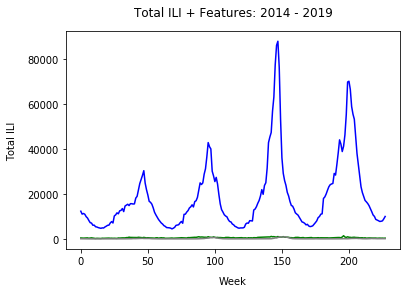

In [185]:
plt.plot(list_hospital, c='blue')
plt.plot(list_tweets, c='green')
plt.plot(list_aus, c='gray')
plt.xlabel("Week", labelpad=10)
plt.ylabel("Total ILI", labelpad=10)
plt.title("Total ILI + Features: 2014 - 2019", pad=15)

### Predicting a previous year

In [186]:
list_hospital_real = list_hospital[:-104]
list_tweets_real = list_tweets[:-104]
list_aus_real = list_aus[:-104]
list_google_real = list_google[:-104]

list_hospital_pred = list_hospital[-104:-52]
list_tweets_pred = list_tweets[-104:-52]
list_aus_pred = list_aus[-104:-52]
list_google_pred = list_google[-104:-52]

# Comment out these lines to only train on the data before where predictions will take place
list_hospital_real.extend(list_hospital[-52:])
list_tweets_real.extend(list_tweets[-52:])
list_aus_real.extend(list_aus[-52:])
list_google_real.extend(list_google[-52:])

In [187]:
features_transposed = [list_tweets_real, list_aus_real]
pred_transposed = [list_tweets_pred, list_aus_pred]

features = list(map(list, zip(*features_transposed)))
pred = list(map(list, zip(*pred_transposed)))

for feature_index in range(len(features)):
    features[feature_index].extend(list_google_real[feature_index])

for pred_index in range(len(pred)):
    pred[pred_index].extend(list_google_pred[pred_index])

In [188]:
model = SARIMAX(endog=list_hospital_real, exog=features, order=(1, 1, 0), seasonal_order=(1, 1, 0, 52), enforce_stationarity=False, enforce_invertibility=False, trend='c')
model_fit = model.fit()

C:\Users\steph\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [189]:
future = 52
predictions = model_fit.predict(len(list_hospital_real), len(list_hospital_real) + future - 1, exog=pred)
future_weeks = list(range(len(list_hospital_real) - future, len(list_hospital_real)))

In [190]:
predictions_df = pd.DataFrame([future_weeks, predictions]).transpose()
predictions_df.columns = ['Week', 'Total ILI']
predictions_df = predictions_df.set_index('Week')

Text(0.5, 1.0, 'Total ILI: 2015-2016 to 2018-2019 + predictions \n(flu-related Google search terms)')

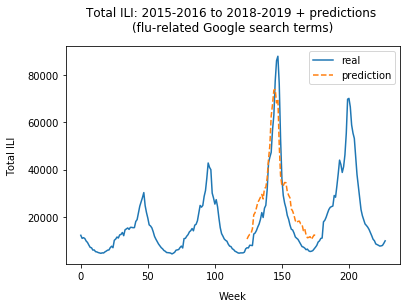

In [191]:
plt.plot(df_hospital['ILI'], label='real')
plt.plot(predictions_df, '--', label='prediction')
plt.legend()
plt.xlabel("Week", labelpad=10)
plt.ylabel("Total ILI", labelpad=10)
plt.title("Total ILI: 2015-2016 to 2018-2019 + predictions \n(flu-related Google search terms)", pad=15)

In [192]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  176
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 52)   Log Likelihood                -623.348
Date:                            Tue, 10 Dec 2019   AIC                           1276.695
Time:                                    23:05:35   BIC                           1310.423
Sample:                                         0   HQIC                          1290.092
                                            - 176                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -15.0095    360.279     -0.042      0.967    -721.143     691.124
x1            -2.1877      1.994     -1.097      0.273      -6.096       1.721
x2           -21.0313      4.999     -4.207      0.000     -30.830     -11.233
x3           117.2795    181.024      0.648      0.517    -237.522     472.081
x4           -53.3685    151.447     -0.352      0.725    -350.200     243.463
x5           425.6752    222.021      1.917      0.055      -9.477     860.827
x6          -242.5518    188.450     -1.287      0.198    -611.908     126.804
x7            11.0231    129.581      0.085      0.932    -242.951     264.997
x8           -90.6069    188.315     -0.481      0.630    -459.697     278.483
x9           -16.7447    147.919     -0.113      0.910    -306.660     273.171
x10           65.2276    180.849      0.361      0.718    -289.230     419.685
x11          -26.2390     86.006     -0.305      0.760    -194.808     142.330
ar.L1          0.1107      0.252      0.440      0.660      -0.383       0.604
ar.S.L52      -0.0063      0.149     -0.042      0.966      -0.299       0.286
sigma2      3.229e+06   7.01e+05      4.605      0.000    1.85e+06     4.6e+06
===================================================================================
Ljung-Box (Q):                       22.95   Jarque-Bera (JB):               197.47
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.86   Skew:                             1.43
Prob(H) (two-sided):                  0.14   Kurtosis:                        10.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""